# Initial Data Merge:

In [14]:
import pandas as pd
import numpy as np
import os
os.chdir('C:/Users/jacki/OneDrive/Documents/FA21/470.708 - Python/Data Location Assignment/Clean CSV Data')
#########
#   1   #
#########
# Import State Party Data:
state_party_control_2018 = pd.read_csv('U.S._State_party-control_2018.csv')
# Subset columns of interest only:
state_party_control_2018 = state_party_control_2018.iloc[:, [0,12,13]]   
# Create clean State Party Control Variable, including DC and Nebraska:
state_party_control_2018['state_party_control'] = np.where((state_party_control_2018['Legis_Control'] == 'Rep') & 
                                                  (state_party_control_2018['Gov_Party'] == 'Rep') |
                                                  (state_party_control_2018['STATE'] == 'Nebraska'),
                                                  "Republican", 
                                                  np.where((state_party_control_2018['Legis_Control'] == 'Dem') & 
                                                  (state_party_control_2018['Gov_Party'] == 'Dem') |
                                                  (state_party_control_2018['STATE'] == 'District of Columbia'),
                                                  "Democratic", 
                                                  "Divided"))
# Remove 'Legis_Control', 'Gov_Party','state_party_control'; they will not be used in further analysis:
state_party_control_2018 = state_party_control_2018.iloc[:, [0,3]]  
#########
#   2   #
#########
# Import State Life Expectancy Estimates:
state_life_expty_est_2018 = pd.read_csv('U.S._State_life_expty_2018.csv')    
# Merge the dataframes on State:
state_life_expty_2018 = pd.merge(state_party_control_2018,state_life_expty_est_2018,on='STATE')
# Remove extra variables about state legislator counts:
state_life_expty_2018 = state_life_expty_2018[['STATE','life_expty_est','state_party_control']]
#########
#   3   #
#########
# Import Census Estimates:
census_work_2018 = pd.read_csv('U.S._State_census_employmentinsurancedemodata_2018.csv')
# Select columns of interest:
census_work_2018 = census_work_2018[['STATE', 
                                     'Percent_Estimate_HEALTH_INSURANCE_COVERAGE_Civilian_noninstitutionalized_population_No_health_insurance_coverage',
                                     'Percent_Estimate_HEALTH_INSURANCE_COVERAGE_Civilian_noninstitutionalized_population_With_health_insurance_coverage_With_private_health_insurance',
                                     'Estimate_INCOME_AND_BENEFITS_(IN_2018_INFLATION-ADJUSTED_DOLLARS)_Total_households_Median_household_income_(dollars)',
                                     'Percent_Estimate_COMMUTING_TO_WORK_Workers_16_years_and_over_Car,_truck,_or_van_--_drove_alone',
                                     'Percent_Estimate_COMMUTING_TO_WORK_Workers_16_years_and_over_Worked_at_home']]
# Rename columns:
census_work_2018.columns = ['STATE',
                            'percent_insurance_none',
                            'percent_insurance_private',
                            'income_household_median',
                            'percent_commute_vehicle_alone',
                            'percent_commute_none']
# Merge the dataframes on State:
state_life_expty_2018 = pd.merge(census_work_2018,state_life_expty_2018,on='STATE')
#########
#   4   #
#########
# Import State GDP (all domestic industries, in millions) Estimates: 
state_gdp_est_2018 = pd.read_csv('U.S._State_GDP-est-allindustry_2018.csv')
# Create GDP in actual millions:
state_gdp_est_2018['GDP_est_2018'] = state_gdp_est_2018['2018_GDP_est_millions']*1000000
# Check variables are aligned:
# pd.options.display.float_format = '{:,.0f}'.format 
# state_gdp_est_2018['2018_GDP_est']
# Drop the Region & Millions column:
state_gdp_est_2018 = state_gdp_est_2018.iloc[:, [0,3]]  
# Merge the dataframes on State:
state_life_expty_2018 = pd.merge(state_gdp_est_2018,state_life_expty_2018,on='STATE')
#########
#   5   #
#########
# Import State Population Estimates: 
state_pop_est_2018 = pd.read_csv('U.S._State_census_totalpopest_2018.csv')
# Merge the dataframes on State:
state_life_expty_2018 = pd.merge(state_pop_est_2018,state_life_expty_2018,on='STATE')

#################
#   WRANGLING   #
#################

# Create Per Capita GDP Variable:
# According to this method: http://pressbooks-dev.oer.hawaii.edu/principlesofeconomics/chapter/19-4-comparing-gdp-among-countries/
state_life_expty_2018['per_capita_GDP'] = state_life_expty_2018['GDP_est_2018']/(state_life_expty_2018['estimated_total_population'])

# Drop variables used to create per capita GDP; they won't be used in analysis:
state_life_expty_2018 = state_life_expty_2018.drop(['estimated_total_population','GDP_est_2018'],axis=1)

# Can retain a copy of data with DC "just in case":
# state_dc_life_expty_2018 = state_life_expty_2018

# Drop DC for regression analysis (due to outlier issue):
state_life_expty_2018 = state_life_expty_2018.drop(8)

# Check merge success:
# state_life_expty_2018.STATE # Does not contain DC
# state_life_expty_2018.columns # Contains correct columns

# Part I: Background Information
#### 1. State the research question: What is the relationship between ______ and _______?
What is the relationship between annual *per capita GDP* and *estimated life expectancy* in US states?

#### 2. Write a short paragraph that provides some context for the research question.  Why is this an interesting relationship to study?  Why do you expect there to be a relationship?
Economists and Politicians alike often equate the dollar measure of GDP to a measure of the overall health and wellbeing of a geographic area.  On a global scale, nations can have incredibly different GDPs.  Developed nations typically have higher GDPs, and corresponding higher standards of living compared to undeveloped nations (e.g., better access to clean water and health care).  So, how does this assumption hold up when applied only to one developed nation, with 50 diverse states, all with differing GPDs? This analysis will explore how US state per capita GDPs relate to estimated state life expectancies, using 2018 data. Life expectancy will serve as a relatively straight-forward interpretation of "overall health and wellbeing" for the purposes of this analysis.  While I do expect there to be a relationship between per capita GDP and life expectancy, I think there are stronger predictors. To keep the analysis as aligned as possible, variables that are directly related to the human capital aspect of GDP have been selected.  The idea is to explore if variables that reflect a greater investment in an employee by an employer are stronger predictors of life expectancy than the dollar measure of GDP itself.  Variables considered to reflect a "greater investment" include wages (median income), flexibility of work environment (commute in vehicle vs. no commute), and insurance (no health insurance vs. private insurance). State political party control has also been included, as Republican states tend to have smaller populations of union members.  Low rates of union membership may be an indicator of overall worse working conditions on average in a state.
 

#### 3. Cite the datasets you’ll be using:  

__**Dependent Variable Dataset:**__
 
- Arias, Elizabeth, Brigham Bastian, Jiaquan Xu, and Betzaida Tejada-Vera. “U.S. Life Expectancy by State and Sex for 2018.” Centers for Disease Control and Prevention. Centers for Disease Control and Prevention, May 12, 2021. https://www.cdc.gov/nchs/data-visualization/state-life-expectancy/. 

__**Independent Variable Datasets:**__
- Williams, Ben, and John Mahoney. “2018 State & Legislative Partisan Composition.” National Conference of State Legislators, January 10, 2018. https://www.ncsl.org/Portals/1/Documents/Elections/Legis_Control_011018_26973.pdf
- “2018 American Community Survey 1-Year Estimates Data Profiles: Selected Economic Characteristics.” United States Census Bureau, 2019. https://data.census.gov/cedsci/table?q=DP03&amp;g=0100000US%240400000&amp;y=2018&amp;tid=ACSDP1Y2018.DP03. 
- “2018 American Community Survey 1-Year Estimates Subject Tables: Age and Sex.” United States Census Bureau, 2019. https://data.census.gov/cedsci/table?q=United+States&amp;t=Age+and+Sex%3APopulations+and+People&amp;g=0400000US01%2C02%2C04%2C05%2C06%2C08%2C09%2C10%2C11%2C12%2C13%2C15%2C16%2C17%2C18%2C19%2C20%2C21%2C22%2C23%2C24%2C25%2C26%2C27%2C28%2C29%2C30%2C31%2C32%2C33%2C34%2C35%2C36%2C37%2C38%2C39%2C40%2C41%2C42%2C44%2C46%2C47%2C48%2C49%2C50%2C51%2C53%2C54%2C55%2C56&amp;y=2018&amp;tid=ACSST1Y2018.S0101&amp;hidePreview=true&amp;tp=true. 
- “Gross Domestic Product by State, Fourth Quarter and Annual 2018.” Bureau of Economic Analysis, May 1, 2019. https://apps.bea.gov/regional/histdata/releases/0519gdpstate/index.cfm. 
 
*Note: All data is exclusive to 2018, and all units of analyses were State Name*

#### 4. Complete Table 1.  Only include those variables you’ll be using in your analysis.  Adjust the number of rows as necessary. 

In [15]:
from IPython.display import HTML

<table>

<tr>
<th><center>Variable Name</center></th>
<th><center>Definition (All Variables & Definitions Reflect 2018 data)</center></th>
</tr>
    
<tr>
<td><center>Estimated Life Expectancy<br>life_expty_est</center></td>
<td><center>Average life expectancy estimate per state, calculated by the CDC.<br>Measured in Years.</center></td>
</tr>

<tr>
<td><center>Per Capita GDP<br>per_capita_GDP</center></td>
<td><center>A state’s GDP estimate reflects the estimated value of the goods and services produced by a state in a year.<br>Total GDPs have been divided by each respective state's total population for a per capita (per person) estimate.<br>Measured in USD.</center></td>
</tr>

<tr>
<td><center>State Party Control<br>state_party_control</center></td>
<td><center>Determined by dominate party of the state Legislature, and the party of the Governor in 2018.<br>Measured as "Republican" "Divided" or "Democratic" (see note below for further details)*</center></td>
</tr>

<tr>
<td><center>% of All State Residents with No Health Insurance<br>percent_insurance_none</center></td>
<td><center>Reflects all civilian, non-institutionalized people with no health insurance.<br>Measured as a percent of total state population.</center></td>
</tr>    

<tr>
<td><center>% of All State Residents with Prviate Health Insurance<br>percent_insurance_private</center></td>
<td><center>Reflects all civilian, non-institutionalized people with private insurance.<br>Measured as a percent of total state population.</center></td>
</tr> 
    
<tr>
<td><center>Median Household Income (Including benefits)<br>income_household_median</center></td>
<td><center>The dataset was edited in 2019 to adjust the dollar estimate for inflation, and includes an average estimate of benefits.<br>Measured in USD.</center></td>
</tr> 
    
<tr>
<td><center>% of Workers 16+ Commuting to Work Alone in Car<br>percent_commute_vehicle_alone</center></td>
<td><center>Reflects workers (only) commuting to work alone and in car, truck, or van.<br>Measured as a percent of total state 16+ population.</center></td>
</tr> 
    
<tr>
<td><center>% of Workers 16+ No Commute (Work from Home)<br>percent_commute_none</center></td>
<td><center>Reflects workers (only) with no commute. These workers work from home.<br>Measured as a percent of total state 16+ population.</center></td>
</tr> 
    
<tr>
<td><center>US State<br>STATE</center></td>
<td><center>Unit of analysis. Contains all 50 US states.</center></td>
</tr>  
    
</table>

***Note about 'State Party Control' variable:** Legislature dominance is determined by number of Representatives per party + number of Senators per party, per each state. If Republicans have the majority in the legislature, it is considered a Republican-dominated Legislature. (There were no “ties” in terms of number of legislators, and there were no instances in which Independents outweighed members of the Democratic/Republican party).  If the dominate party of the legislature aligns with the party of the governor (e.g., both are Democratic, or both are Republican), the state is coded as that party.  If the parties of the legislature and the governor do not align, the state is coded as Divided.  
Though unicameral, Nebraska is included, and coded as Republican given the party affiliations of the Legislators in 2018, and the party of the Governor.

# Part 2: Descriptive Information
#### 5. Complete the table of summary statistics.  Add or delete rows as necessary.

Below are three outputs. The first output contains descriptive statsitics of the numeric variables.  The second output shows the count of each value for the categorical variable, State Party Control.  The third contains the same information as the second output, but expressed as a percent of total observations rather than as a count.

In [16]:
import numpy as np
import pandas as pd

# Complete the table of summary statistics.
pd.options.display.float_format = '{:,.2f}'.format
state_life_expty_2018.describe()

,percent_insurance_none,percent_insurance_private,income_household_median,percent_commute_vehicle_alone,percent_commute_none,life_expty_est,per_capita_GDP
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,8.19,69.04,"61,549.28",78.00,5.28,78.22,"58,848.76"
std,3.04,5.48,"10,184.02",5.76,1.24,1.72,"11,081.00"
min,2.80,54.30,"44,097.00",53.10,2.60,74.40,"38,207.22"
25%,5.70,65.12,"55,361.50",75.45,4.43,77.20,"51,003.02"
50%,8.00,70.05,"59,760.50",79.50,5.15,78.65,"57,543.01"
75%,10.07,73.70,"69,697.25",82.07,6.07,79.30,"65,426.26"
max,17.70,79.70,"83,242.00",86.30,8.60,81.00,"85,781.00"


In [17]:
state_life_expty_2018['state_party_control'].value_counts()

Republican    26
Divided       14
Democratic    10
Name: state_party_control, dtype: int64

In [18]:
state_life_expty_2018['state_party_control'].value_counts(normalize = True)

Republican   0.52
Divided      0.28
Democratic   0.20
Name: state_party_control, dtype: float64

#### 6. Create one visualization of the dependent variable (e.g. bar graph, line graph, boxplot, histogram).  Be sure the visualization includes all the critical components, including a title, meaningful axes labels and any other useful labels.

In [19]:
# Make plots print centered:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

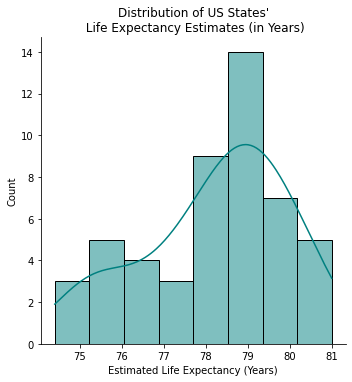

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make histogram with density line plotted:
dv_hist=sns.displot(state_life_expty_2018['life_expty_est'],
                    kde=True,
                    bins=8,
                    color='teal')
dv_hist.set(title='Distribution of US States\'\n Life Expectancy Estimates (in Years)',
            xlabel='Estimated Life Expectancy (Years)')
plt.show()

#### 7. Write a one-sentence summary of the visualization above.  What is something interesting about the variable that the visualization highlights?
The estimated life expectancy distribution ranges from about 74-81 years, and is negatively skewed towards higher ages, with 79 years being the most commonly reported life expectancy in the dataset. Interesting about this visual, is the potential for two different distributions within the dataset: note the two slight peaks made apparent by the density line, one around lower ages, one around higher ages.

#### 8. Create one visualization of the independent variable of interest (e.g. bar graph, line graph, histogram).  Be sure the visualization includes all the critical components, including a title, meaningful axes labels and any other useful labels.  If you have more than one independent variable of interest, select one for this question.

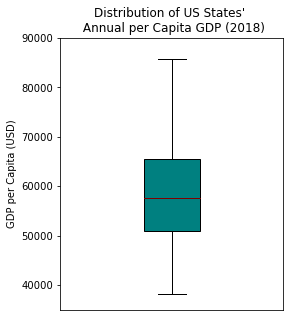

In [21]:
# Set figure size to eliminate white space:
fig = plt.figure()
fig.set_figwidth(4)
fig.set_figheight(5)
# Create base box plot:
gdp_bx = plt.boxplot(state_life_expty_2018['per_capita_GDP'],
            widths=[0.25],
            patch_artist=True)
# Set titles and labels:
plt.ylabel("GDP per Capita (USD)")
plt.title("Distribution of US States\' \n Annual per Capita GDP (2018)")
plt.xticks([])
plt.tick_params(bottom=False) 
plt.ylim(35000,90000)
# Add Color:
for median in gdp_bx['medians']:
    median.set(color ='maroon',
               linewidth = 1)
color = ['teal']
for patch, color in zip(gdp_bx['boxes'], color):
    patch.set_facecolor(color) 

#### 9. Write a one-sentence summary of the visualization above.  What is something interesting about the variable that the visualization highlights?
The distribution of 2018 per capita GDP is slightly positively skewed towards lower GDPs, as evidenced by the median line (representing \\$57,543) being slightly towards the bottom of the box, and the bottom whisker being slightly shorter than the top whisker (representing a range of \\$38,207-\\$85,781).  Interesting about this variable, is that there are no outliers in the data when the GDP is conceptualized as a per capita measure; when expressed as total state GDP, disregarding population, California, Texas, and New York all represent high outliers.

#### 10. Create one bivariate relationship that shows the relationship between the two variables used above (e.g. scatter plot, side-by-side bar plot, line graph). 

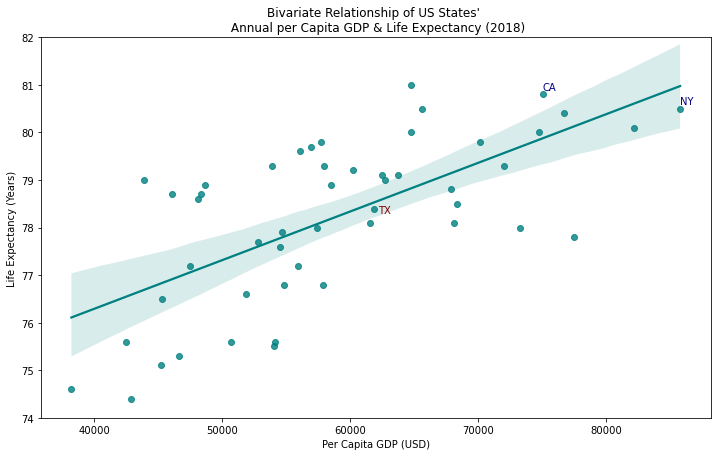

In [22]:
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(7)
IV_DV_plot=sns.regplot(y=state_life_expty_2018['life_expty_est'],
                 x=state_life_expty_2018['per_capita_GDP'],
                 label=state_life_expty_2018['STATE'],
                 scatter=True,
                 fit_reg=True, 
                 ci=95,
                 color='teal')
IV_DV_plot.set(ylim=(74,82))
plt.xlabel("Per Capita GDP (USD)")
plt.ylabel("Life Expectancy (Years)")
plt.title("Bivariate Relationship of US States\' \n Annual per Capita GDP & Life Expectancy (2018)")   
plt.text(75033.855537, 80.9, "CA", color="navy")
plt.text(85780.998453, 80.6, "NY", color="navy")
plt.text(62200, 78.3, "TX", color="maroon")
plt.show()

############
# Determining Label Posisitions:
# TX: 
# state_life_expty_2018.loc[43,] # per_capita_GDP: 61870, life_expty_est:  78.4
# NY: 
# state_life_expty_2018.loc[32,] # per_capita_GDP: 85780, life_expty_est: 80.5
# CA: 
# state_life_expty_2018.loc[4,] # per_capita_GDP: 75033, life_expty_est: 80.8
# DC:
# state_life_expty_2018.loc[8,] # per_capita_GDP: 199699, life_expty_est: 77.7
############

#### 11. Write a one-sentence summary of the visualization above.  What is something interesting about the relationship that the visualization highlights?
This scatterplot depicts the somewhat weak positive relationship between per capita GDP and life expectancy per US State (the regression line and shaded 95% confidence interval are included to help guide the eye, and show where most of the points would land if the variables were very strongly correlated).  Interesting about this plot, is the 3 *total GDP* outlier states mentioned in Q9 are labeled in the colors of their respective political party; although conservative Texas has an extremely high total GDP, it has a relatively average per capita GDP and life expectancy, while the other two outlier states (Democratic CA and NY) have notably higher per capita GPDs and life expectancies.

# Part 3: Regression Analysis
#### 12a. Run a bivariate regression model that includes your dependent variable and one independent variable of interest.

In [23]:
import statsmodels.formula.api as smf

bv_model=smf.ols('life_expty_est ~ per_capita_GDP', data=state_life_expty_2018)
bv_results=bv_model.fit()

## Print results as table:
bv_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         life_expty_est   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     37.07
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           1.84e-07
Time:                        20:49:13   Log-Likelihood:                -83.154
No. Observations:                  50   AIC:                             170.3
Df Residuals:                      48   BIC:                             174.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         72.2018      1.005     71.809      0.000      70.180      74.223
per_capita_GDP     0.0001   1.68e-05      6.089      0.000    6.85e-05       0.000
==============================================================================
Omnibus:                        5.014   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                2.055
Skew:                          -0.068   Prob(JB):                        0.358
Kurtosis:                       2.016   Cond. No.                     3.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 12b.  Run a multivariate regression model that includes your dependent variable, one or more independent variables of interest and at least one control variable.

In [24]:
mv_model=smf.ols('life_expty_est ~ per_capita_GDP +state_party_control + percent_insurance_none + percent_insurance_private + income_household_median + percent_commute_vehicle_alone + percent_commute_none', data=state_life_expty_2018)
# note: using C(state_party_control) produced the same output
mv_results = mv_model.fit()

## Print results as table:
mv_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         life_expty_est   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     17.63
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           4.92e-11
Time:                        20:49:13   Log-Likelihood:                -60.196
No. Observations:                  50   AIC:                             138.4
Df Residuals:                      41   BIC:                             155.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            71.8888      3.590     20.022      0.000      64.638      79.140
state_party_control[T.Divided]       -0.6282      0.425     -1.479      0.147      -1.486       0.230
state_party_control[T.Republican]    -0.7873      0.551     -1.428      0.161      -1.901       0.326
per_capita_GDP                     1.108e-05   2.16e-05      0.514      0.610   -3.25e-05    5.46e-05
percent_insurance_none               -0.0122      0.057     -0.213      0.832      -0.128       0.104
percent_insurance_private             0.0814      0.040      2.043      0.048       0.001       0.162
income_household_median            3.879e-05   2.75e-05      1.411      0.166   -1.67e-05    9.43e-05
percent_commute_vehicle_alone        -0.0501      0.035     -1.441      0.157      -0.120       0.020
percent_commute_none                  0.4303      0.124      3.463      0.001       0.179       0.681
==============================================================================
Omnibus:                        3.586   Durbin-Watson:                   2.658
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                1.837
Skew:                           0.147   Prob(JB):                        0.399
Kurtosis:                       2.108   Cond. No.                     2.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <center>Table 3: Regression Results</center>
##### Dependent variable: Estimated Life Expectancy (per state, in years)
*Note: Some coeffients and standard errors round to 0.00.  Please see above outputs for those numbers with a greater degree of accuracy.

<table>
<tr>
<th>Independent Variable</th>
<th>Bivariate Model<br><i>Est. Coefficient</i><br><i>(Est. Standard Error)</i></th>
<th>Multivariate Model<br><i>Est. Coefficient</i><br><i>(Est. Standard Error)</i></th>
</tr>
<tr>
<td>Per Capita GDP</td>
<td>0.00<br>(0.00)</td>
<td>0.00<br>(0.00)</td>
</tr>
<tr>
<td>State Party Control (Republican)</td>
<td> </td>
<td>-0.79<br>(0.55)</td>
</tr>
<tr>
<td>State Party Control (Divided)</td>
<td> </td>
<td>-0.63<br>(0.43)</td>
</tr>
<tr>
<td>No Health Insurance</td>
<td> </td>
<td>-0.01<br>(0.06)</td>
</tr>
<tr>
<td>Private Health Insurance</td>
<td> </td>
<td>0.08<br>(0.04)</td>
</tr>
<tr>
<td>Median Income</td>
<td></td>
<td>0.00<br>(0.00)</td>
</tr>
<tr>
<td>Commute to Work in Car Alone</td>
<td></td>
<td>-0.05<br>(0.03)</td>
</tr>
<tr>
<td>No Commute to Work (Work from Home)</td>
<td></td>
<td>0.43<br>(0.12)</td>
</tr>
<tr>
<td>N (# of observations)</td>
<td>50</td>
<td>50</td>
</tr>
</table>

#### 13. Explain your justification for one of the control variables that you chose to include in the multivariate model.
One control variable included is **state party control**; political party tends to influence various state laws that directly impact the work force.  For example, Connecticut is a long-term Blue state with various work-force protection laws, like a state-mandated paid family leave program, and a minimum wage law (that will raise wages to \\$15/hr by 2023). Connecticut also has a robust union network that helped bring these laws to fruition.  In contrast, Red state South Carolina has the lowest union membership in the country, a minimum wage of \\$7.25/hr, and only offers federally mandated unpaid family leave to non-salaried workers.  

Divided states can comparatively be a bit of a "mixed bag" in regard to labor protections. For example, Massachusetts falls into the divided category for 2018, and has relatively strong union membership and worker protections (e.g., minimum wage above the federally mandated level, paid family leave, and the notorious Massachusetts health care expansion, which achieved nearly universal health care in a short period of time, before the Affordable Care Act).  On the other hand, North Carolina was also a Divided state in 2018, and has extremely low union membership, no paid family leave, and the low, federally mandated minimum wage.

The intention of the variables selected for multivariate analysis was again to reflect the idea that an employer is investing in the wellbeing of their employee.  Given some of the anecdotal evidence provided here, it is reasonable to assume there are inherent differences in an employer’s ability to do so given the state they are in (e.g., a small business would likely have a harder time providing paid family leave in South Carolina than in Connecticut. In Connecticut, the leave will be funded via a statewide 0.5% payroll deduction).

Sources:  
(1) “Workforce Laws and Regulations.” Connecticut's Official State Website. Accessed December 12, 2021. https://portal.ct.gov/Services/Jobs-and-Employment/Employee-Rights/Workforce-Laws-and-Regulations.    

(2) “Southwest Information Office.” U.S. Bureau of Labor Statistics, February 1, 2021. https://www.bls.gov/regions/southwest/news-release/unionmembership_texas.htm.     

(3) “Massachusetts Health Care Reform--On Second Anniversary of Passage, What Progress Has Been Made?” The Commonwealth Fund. Accessed December 12, 2021. https://www.commonwealthfund.org/publications/newsletter-article/massachusetts-health-care-reform-second-anniversary-passage-what.     

(4) Haney, Kevin. “South Carolina Maternity &amp; Family Medical Leave Laws.” Growing Family Benefits, July 1, 2021. https://www.growingfamilybenefits.com/south-carolina-maternity-leave-laws/.     


#### 14. Interpret the coefficient on the independent variable of interest in the bivariate model.
**Coefficient:** 0.0001  
**Summary:** With each additional dollar of per capita GDP, there is an estimated increase in state resident life expectancy of 0.0001 years.  (With each additional ten thousand dollars of per capita GDP, there is an estimated increase in state resident life expectancy of 1 year).  
  
The coefficient on per capita GDP is positive and quite small, however, it refers to each dollar increase of per capita GDP.  This means the effect on life expectancy can be strong for large measures of per capita GDP, but relatively weak for low measures per capita GDP.  For example, a low per capita GDP of \\$45,000 produces a life expectancy estimate of 76.7 years (estimated life expectancy = 72.2 + (0.0001\*45000)).  A high per capita GDP of \\$80,000 produces a life expectancy estimate of 80.2 (estimated life expectancy = 72.2 + (0.0001\*80000)).  A life expectancy of 80 years is above average for the dataset, while a life expectancy of 77 years is below average. This indicates that high per capita GDPs may be related to long life expectancy estimates.  This coefficient has a p-value of nearly zero, and a t-statistic greater than the critical value of 1.96, meaning the coefficient is signficant at the 95% confidence level (as well as the 99% confidence level). 


#### 15. Interpret the coefficient on the independent variable of interest in the multivariate model.
**Coefficient:** 0.00001  
**Summary:** With each additional dollar of per capita GDP, there is an estimated increase in state resident life expectancy of 0.00001 years.  (With each additional hundred thousand dollars of per capita GDP, there is an estimated increase in state resident life expectancy of 1 year). 
  
The coefficient on per capita GDP is positive, and has been rendered statistically insignificant in the presence of other variables. The t-statistic is 0.51 with a p-value of 0.61; neither metric meets tradtionally accepted thresholds for significance. Further, because the size of the coefficient is smaller than it was in the bivariate model, per capita GDP also has a notably weaker (insignificant) effect overall on life expectancy estimates in the multivariate model. 

#### 16. Conduct a hypothesis test on the independent variable of interest in the multivariate model.  State the null hypothesis, alternative hypothesis, t-score and result of the test.
•	**H0:**  State-level per capita GDP does not have a statistically significant relationship with life expectancy estimates (per state).   
•	**HA:**  State-level per capita GDP has a statistically significant relationship with life expectancy estimates (per state).  
•	**t-score:**  0.51 (p-value: 0.61)  
•	**Result of the test:**  Retain the null hypothesis; there is not a statistically significant relationship at alpha 0.05.

#### 17. In a few sentences, describe your overall findings from your analysis.
The bivariate analysis reveals a significant relationship between per capita GDP and estimated life expectancy at the 95% confidence level. It suggests that with each additional ten thousand dollars of per capita GDP, there is an estimated increase in state resident life expectancy of 1 year. However, the multivariate analysis suggests that the bivariate model is likely oversimplified.  

Adding variables to the model that are more relevant to the human capital aspect of GDP revealed a weaker, insignificant relationship between per capita GDP and life expectancy. This suggests that variables signaling a greater investment in human capital (i.e., a greater investment in employees by employers) may be more significant predictors of life expectancy than GDP itself in a developed nation.  

At the 95% confidence level, percent of working age residents having no commute to work (working from home), and percent of residents with private health insurance were the only significant predictors of life expectancy in the multivariate model.  These coefficients can also have relatively strong magnitudes depending on other inputs. Working from home as a predictor of health, wellbeing, or life expectancy may warrant greater exploration in future studies; particularly as working from home proliferates across the country as a more standard practice.  

It is notable that having no commute to work had a relatively strong statistically significant effect in this model, considering some of the other variables seemed "more intuitive" to the relationship overall.  For example, one might expect states with a high median income would have a statistically significant positive effect on life expectancy. Counterintuitively, the effect was statistically insignificant. The insignificance of median income may suggest that a measure of wealth dispersion (i.e., income inequality) would be a fruitful next step for exploration. States with a high degree of wealth dispersion may provide insight on where and why the poor are experiencing worse health outcomes, or other socioeconomic outcomes, than the wealthy in the US.

The R-squared value of the bivariate model is 0.436, indicating approximately 44% of the variation in state life expectancy estimates can be explained by per capita GDP alone. This metric does not assert causality, but does suggest that the bivariate regression model fits the observed data moderately well. The multivariate models adjusted R-squared value of 0.731 indicates that the model explains approximately 73% of the variation in estimated life expectancy. This model more strongly fits the observed data compared to the bivariate model.  